In [1]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.TMSUtilities.GetCuts import Cut
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time,copy

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 15

analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile('/g/g90/jacopod/software/TMSAnalysis/config/Run_Parameters_Xe_Run29.csv')
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']
path_to_reduced = '/p/lustre1/jacopod/29th/TMS_analysis/20200213_AfterRnInjection'

In [2]:
start_time = time.time()
df = pd.read_hdf(path_to_reduced + '/reduced_added.h5')
print('dataframe with {} events loaded in {:.1f}s'.format(df.shape[0],time.time() - start_time))
DriftTime = (df['TimeOfMaxChannel'] - trigger_time)*sampling_time
for k in df.keys():
    print(k)

dataframe with 1243966 events loaded in 38.9s
ChannelPositions
ChannelTypes
Event
File
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
TileStrip X1-12 Baseline
TileStrip X1-12 Baseline RMS
TileStrip X1-12 Charge Energy
TileStrip X1-12 Drift Time
TileStrip X1-12 T10
TileStrip X1-12 T25
TileStrip X1-12 T50
TileStrip X1-12 T90
TileStrip X13 Baseline
TileStrip X13 Baseline RMS
TileStrip X13 Charge Energy
TileStrip X13 Drift Time
TileStrip X13 T10
TileStrip X13 T25
TileStrip X13 T50
TileStrip X13 T90
TileStrip X14 Baseline
TileStrip X14 Baseline RMS
TileStrip X14 Charge Energy
TileStrip X14 Drift Time
TileStrip X14 T10
TileStrip X14 T25
TileStrip X14 T50
TileStrip X14 T90
TileStrip X15 Baseline
TileStrip X15 Baseline RMS
TileStrip X15 Charge Energy
TileStrip X15 Drift Time
TileStrip X15 T10
TileStr

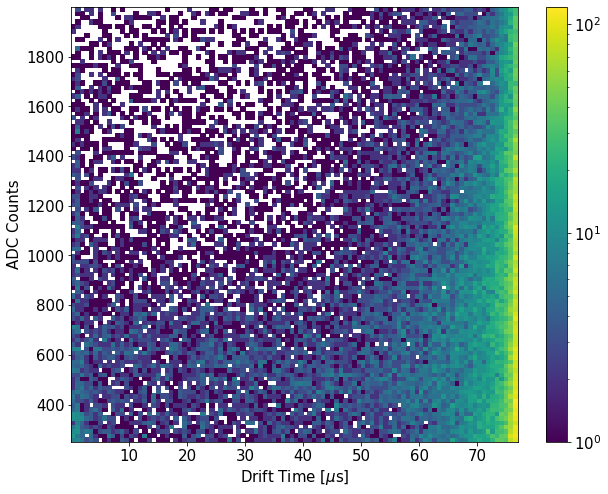

In [3]:
cut_array = ['DriftTime>0', 'DriftTime<77',\
            'TotalTileEnergy>250', 'TotalTileEnergy<2000',\
            'NumXTileChannelsHit==1','NumYTileChannelsHit==1']
derived_dict = {'DriftTime':DriftTime}
cut = Cut(cut_array,df,derived_dict)
mask = cut.mask
plt.hist2d(DriftTime.loc[mask], df['TotalTileEnergy'].loc[mask], bins=100, norm=LogNorm())
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('ADC Counts')
plt.colorbar()

In [4]:
def fit_function(x, A, beta, B, mu, sigma):
    return (A * np.exp(-x/beta) +\
            B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))
def exp_function(x, A, beta):
    return(A * np.exp(-x/beta))

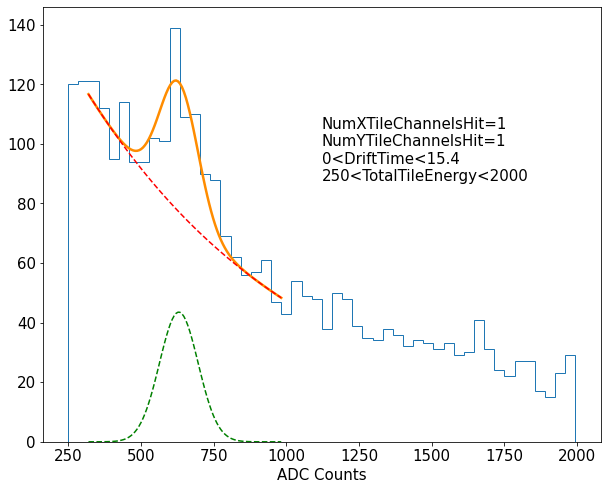

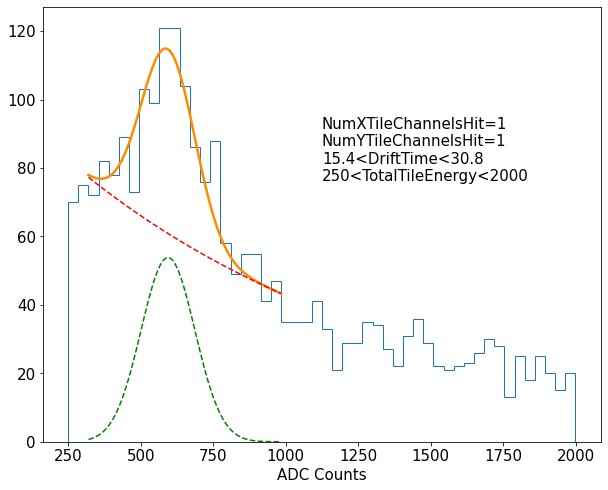

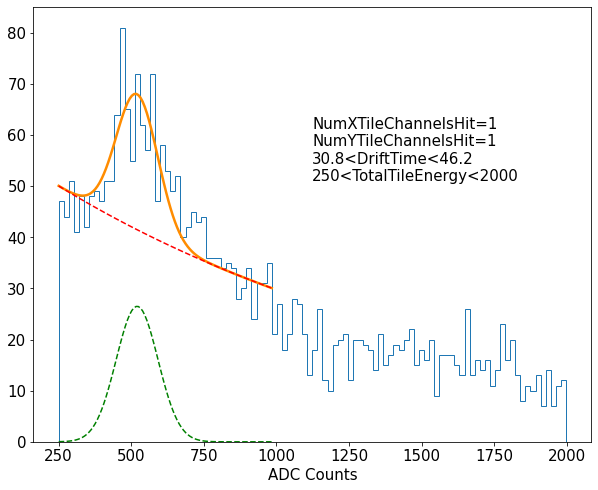

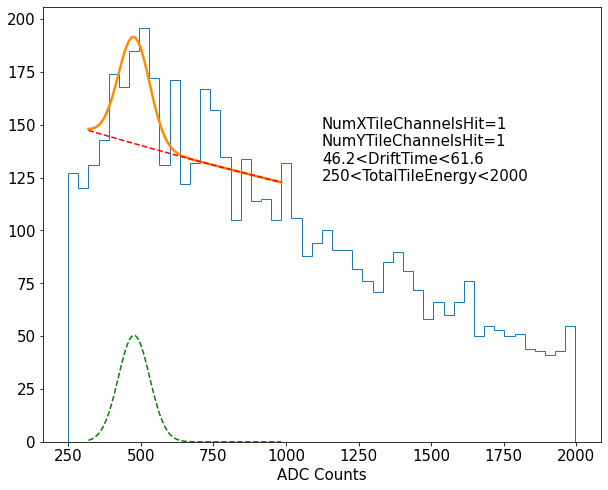

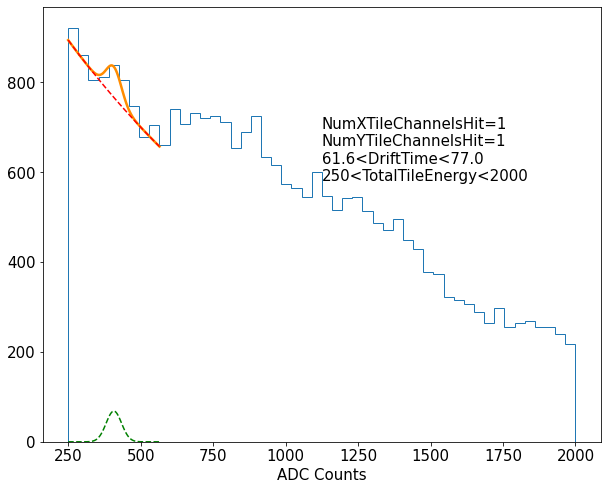

In [9]:

fit_data = {'time':[],'peak':[],'peak_error':[]}
p0 = ([None],[400,800,60,500,40],[200,1000,60,500,80],[150,800,60,500,40],[200,4000,60,500,40],[1500,2800,120,400,40])
slices = 6
for i,rg in enumerate(np.linspace(0,77,slices)):
    bins = 50
    fit_range = [300,1000]
    if i == 0:
        rg_0 = 0
        continue
    if i == slices - 1:
        fit_range = [250,600]
    if i  == 3:
        bins = 100
        fit_range = [250,1000]
    cut_array1 = cut_array[2:] + ['DriftTime>{}'.format(rg_0), 'DriftTime<{}'.format(rg)]
    cut1 = Cut(cut_array1,df,derived_dict)
    mask1 = cut1.mask
    data, bin_edges,_ = plt.hist(df['TotalTileEnergy'].loc[mask1],bins=bins,histtype='step')
    bin_width = bin_edges[1]-bin_edges[0]
    fit_idx = np.where((bin_edges>fit_range[0]) & (bin_edges<fit_range[1]))[0]
    popt, pcov = curve_fit(fit_function, xdata=bin_edges[fit_idx], ydata=data[fit_idx],\
                           p0=p0[i],bounds=(np.asarray(p0[i])*0.2,np.asarray(p0[i])*1.8))
    fit_x_bin = np.linspace(bin_edges[fit_idx][0],bin_edges[fit_idx][-1],100)
    plt.plot(fit_x_bin, fit_function(fit_x_bin, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
    popt_buffer = copy.deepcopy(popt)
    for ix,j in zip((0,2),('green','red')):
        popt[ix] = 0
        plt.plot(fit_x_bin, fit_function(fit_x_bin, *popt), color=j, linewidth=1.5,linestyle='dashed')
        popt = copy.deepcopy(popt_buffer)
    plt.text(0.5, 0.6, cut1.GetString('\n'), transform = plt.gca().transAxes)
    plt.xlabel('ADC Counts')
    plt.show()
    fit_data['time'].append((rg + rg_0)/2)
    fit_data['peak'].append(popt[3])
    fit_data['peak_error'].append(np.sqrt(pcov[3,3]) + np.sqrt(popt[3]*bin_width/(popt[2]*np.sqrt(2*np.pi))))
    rg_0 = rg
    
fit_data = pd.DataFrame(fit_data)

Text(0.7, 0.7, 'A = 680.3$\\pm$15.5\n$\\tau$ = 141.9$\\pm$11.6$\\mu$s')

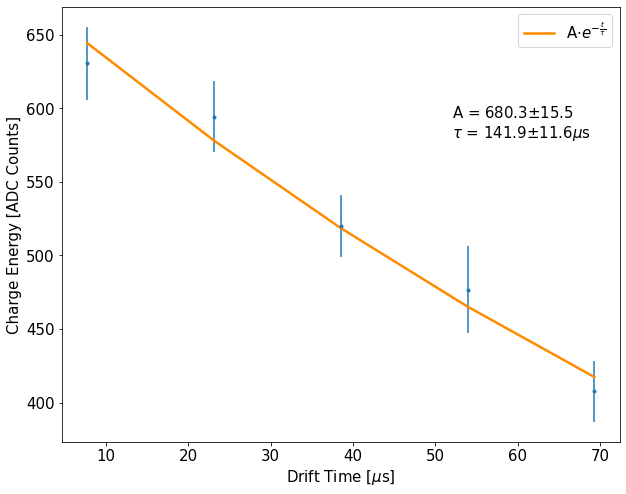

In [6]:
plt.errorbar(fit_data['time'],fit_data['peak'],fit_data['peak_error'],fmt='.')
popt, pcov = curve_fit(exp_function, xdata=fit_data['time'], ydata=fit_data['peak'],\
                       p0=(600,1000),sigma=fit_data['peak_error'])
text = 'A = {:.1f}$\pm${:.1f}'.format(popt[0],np.sqrt(np.diag(pcov))[0])+ '\n' +\
r'$\tau$ = {:.1f}$\pm${:.1f}$\mu$s'.format(popt[1],np.sqrt(np.diag(pcov))[1])
plt.plot(fit_data['time'], exp_function(fit_data['time'], *popt), color='darkorange', linewidth=2.5,\
         label=r'A$\cdot e^{-\frac{t}{\tau}}$')
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('Charge Energy [ADC Counts]')
plt.legend()
plt.text(0.7, 0.7, text, transform = plt.gca().transAxes)